In [1]:
import torch as t
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer
from nlp_moe_model import MoEBertModel
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from train import train_epoch, evaluate, NewsDataset,load_data
import os
from plotting_utils import *

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 2
LEARNING_RATE = 2e-5
NUM_EXPERTS = 8
MODEL_NAME = 'bert-base-uncased'
MAX_LEN = 128
ROUTING = 'soft'  # 'soft' or 'hard' or 'gumbel'
TOP_K = 6 # Only used if ROUTING is 'hard'
FREEZE_BERT = True  # Whether to freeze BERT layers during training
LOAD_BALANCE = True  # Whether to use load balancing loss
LOAD_BALANCE_COEF = 0.5  # Coefficient for load balancing loss


/home/knwldgosint/Documents/Projects/analysis/rocm_env/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def main(model_type='bert'):
    # Configuration
    device = t.device('cuda:0' if t.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    print(f"GPU Name: {t.cuda.get_device_name(0)}")
    print(f"GPU Count: {t.cuda.device_count()}")

    # Forcer toutes les opérations sur ce GPU
    t.cuda.set_device(0)

    entropy_history = []
    expert_usage_history = []
    # Load data
    train_df, test_df, label_encoder, sentiment_encoder = load_data(
        '/home/knwldgosint/Documents/School5/Advanced Neural network/project/Arna/dataset/train_with_sentiment.csv',
        '/home/knwldgosint/Documents/School5/Advanced Neural network/project/Arna/dataset/test_with_sentiment.csv'
    )
    num_classes = len(label_encoder.classes_)
    num_sentiments = len(sentiment_encoder.classes_)
    print(f"Number of classes: {num_classes}")
    print(f"Number of sentiment classes: {num_sentiments}")


    # Tokenizer
    tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

    # Create datasets
    train_dataset = NewsDataset(
        train_df['Description'].tolist(),
        train_df['label_encoded'].tolist(),
        train_df['Sentiment_encoded'].tolist(),
        tokenizer,
        max_length=MAX_LEN
    )
    test_dataset = NewsDataset(
        test_df['Description'].tolist(),
        test_df['label_encoded'].tolist(),
        test_df['Sentiment_encoded'].tolist(),
        tokenizer,
        max_length=MAX_LEN
    )

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True)
    model = None
    # Model
    # if model_type == 'bert':
    model = MoEBertModel(
        pretrained_model_name=MODEL_NAME,
        expert_number=NUM_EXPERTS,
        output_dim=num_classes,
        routing = ROUTING,
        top_k = TOP_K,
        freeze_bert = FREEZE_BERT,
    ).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = t.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

    # Training loop
    best_acc = 0
    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    hyperparam = get_hyperparameters_text()

    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")

        train_loss, train_acc,metrics = train_epoch(model, train_loader, optimizer, criterion, device, load_balance=LOAD_BALANCE, balance_coef=LOAD_BALANCE_COEF)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        entropy_history.append(metrics['avg_entropy'])
        if metrics['expert_usage'] is not None:
            expert_usage_history.append(metrics['expert_usage'])
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

        # Save best model
        if test_acc > best_acc:
            best_acc = test_acc
            t.save(model.state_dict(), 'best_moe_model.pth')
            print("Model saved!")

    print(f"\nBest Test Accuracy: {best_acc:.4f}")

    # Generate analytics plots
    print("\n" + "="*50)
    print("Generating Analytics...")
    print("="*50)

    # Plot training history
    plot_training_history(train_losses, train_accs, test_losses, test_accs, hyperparams=hyperparam)

    # Load best model for final evaluation
    model.load_state_dict(t.load('best_moe_model.pth'))

    # Get predictions for confusion matrix
    _, _, test_predictions, test_labels = evaluate(
        model, test_loader, criterion, device, return_predictions=True
    )

    # Get class names
    class_names = [str(cls) for cls in label_encoder.classes_]

    # Plot confusion matrix
    plot_confusion_matrix(test_labels, test_predictions, class_names, hyperparams=hyperparam)

    # Plot per-class metrics
    plot_per_class_metrics(test_labels, test_predictions, class_names, hyperparams=hyperparam)

    # Print classification report
    print("\nClassification Report:")
    print("="*50)
    print(classification_report(test_labels, test_predictions, target_names=class_names))

    # Analyze expert usage per class
    print("\n" + "="*50)
    print("Analyzing Expert Usage...")
    print("="*50)

    expert_usage = analyze_expert_usage(
        model, test_loader, device, NUM_EXPERTS, num_classes
    )

    # Plot expert usage heatmap
    plot_expert_usage_heatmap(expert_usage, class_names, hyperparams=hyperparam)

    # Plot expert specialization
    plot_expert_specialization(expert_usage, class_names, hyperparams=hyperparam)

    # Plot expert preference heatmap
    plot_expert_preference_heatmap(expert_usage, class_names, hyperparams=hyperparam)
    # Plot expert entropy
    plot_expert_entropy(expert_usage, hyperparams=hyperparam)

    # Plot entropy evolution
    plot_gating_entropy_evolution(entropy_history)

    # Plot expert usage evolution
    if expert_usage_history:
        plot_expert_usage_std_evolution(expert_usage_history, hyperparams=hyperparam)
        plot_expert_usage_evolution(expert_usage_history, hyperparams=hyperparam)
    # Print top experts for each class
    print("\nTop 3 Experts per Class:")
    print("="*50)
    for i, class_name in enumerate(class_names):
        top_experts = np.argsort(expert_usage[i])[::-1][:3]
        print(f"{class_name}: Experts {top_experts} with weights {expert_usage[i][top_experts]}")

    t.cuda.empty_cache()

main()


In [ ]:

def run_ablation_study():
    """Compare different configurations"""
    results = []

    # Configurations to test
    configs = [
        {'num_experts': 4, 'routing': 'soft', 'dropout': 0.3},
        {'num_experts': 8, 'routing': 'soft', 'dropout': 0.3},
        {'num_experts': 4, 'routing': 'hard', 'dropout': 0.3},
        {'num_experts': 8, 'routing': 'hard', 'dropout': 0.3},
        {'num_experts': 4, 'routing': 'soft', 'dropout': 0.5},
        {'num_experts': 4, 'routing': 'gumbel', 'dropout': 0.3},
    ]

    device = t.device('cuda:0' if t.cuda.is_available() else 'cpu')
    train_df, test_df, label_encoder, sentiment_encoder = load_data(
        '/home/knwldgosint/Documents/School5/Advanced Neural network/project/Arna/dataset/train_with_sentiment.csv',
        '/home/knwldgosint/Documents/School5/Advanced Neural network/project/Arna/dataset/test_with_sentiment.csv'
    )
    tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

    train_dataset = NewsDataset(
        train_df['Description'].tolist(),
        train_df['label_encoded'].tolist(),
        train_df['Sentiment_encoded'].tolist(),
        tokenizer, max_length=MAX_LEN
    )
    test_dataset = NewsDataset(
        test_df['Description'].tolist(),
        test_df['label_encoded'].tolist(),
        test_df['Sentiment_encoded'].tolist(),
        tokenizer, max_length=MAX_LEN
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

    for config in configs:
        print(f"\n{'='*50}")
        print(f"Testing: {config}")
        print('='*50)

        model = MoEBertModel(
            pretrained_model_name=MODEL_NAME,
            expert_number=config['num_experts'],
            output_dim=len(label_encoder.classes_),
            routing=config['routing'],
            top_k=2,
            freeze_bert=True,
            dropout=config['dropout']
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = t.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

        # Train for fewer epochs for ablation
        entropy_history = []
        for epoch in range(2):
            train_loss, train_acc, metrics = train_epoch(
                model, train_loader, optimizer, criterion, device,
                load_balance=True, balance_coef=0.1
            )
            entropy_history.append(metrics['avg_entropy'])

        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        # Analyze expert usage
        expert_usage = analyze_expert_usage(
            model, test_loader, device, config['num_experts'], len(label_encoder.classes_)
        )

        # Compute specialization score (inverse of entropy)
        expert_dist = expert_usage / (expert_usage.sum(axis=0, keepdims=True) + 1e-10)
        expert_entropy = -np.sum(expert_dist * np.log(expert_dist + 1e-10), axis=0)
        avg_specialization = 1 - (expert_entropy.mean() / np.log(len(label_encoder.classes_)))

        results.append({
            **config,
            'test_acc': test_acc,
            'avg_entropy': np.mean(entropy_history),
            'specialization': avg_specialization
        })

        t.cuda.empty_cache()

    return pd.DataFrame(results)


df = run_ablation_study()
plot_ablation_results(df)


Testing: {'type': 'dense', 'hidden_mult': 1, 'dropout': 0.3}


2026-01-16 03:23:24.218013: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-16 03:23:24.250543: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-16 03:23:24.926576: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Evaluating: 100%|██████████| 119/119 [00:09<00:00, 12.67it/s]



Testing: {'type': 'dense', 'hidden_mult': 4, 'dropout': 0.3}


Evaluating: 100%|██████████| 119/119 [00:09<00:00, 12.88it/s]



Testing: {'type': 'dense', 'hidden_mult': 8, 'dropout': 0.3}


Evaluating: 100%|██████████| 119/119 [00:09<00:00, 12.77it/s]



Testing: {'type': 'moe', 'num_experts': 4, 'routing': 'soft', 'dropout': 0.3}


Evaluating: 100%|██████████| 119/119 [00:09<00:00, 12.62it/s]



Testing: {'type': 'moe', 'num_experts': 8, 'routing': 'soft', 'dropout': 0.3}


Evaluating: 100%|██████████| 119/119 [00:09<00:00, 12.53it/s]



Testing: {'type': 'moe', 'num_experts': 4, 'routing': 'hard', 'dropout': 0.3}


Evaluating: 100%|██████████| 119/119 [00:09<00:00, 12.53it/s]


KeyError: 'specialization'

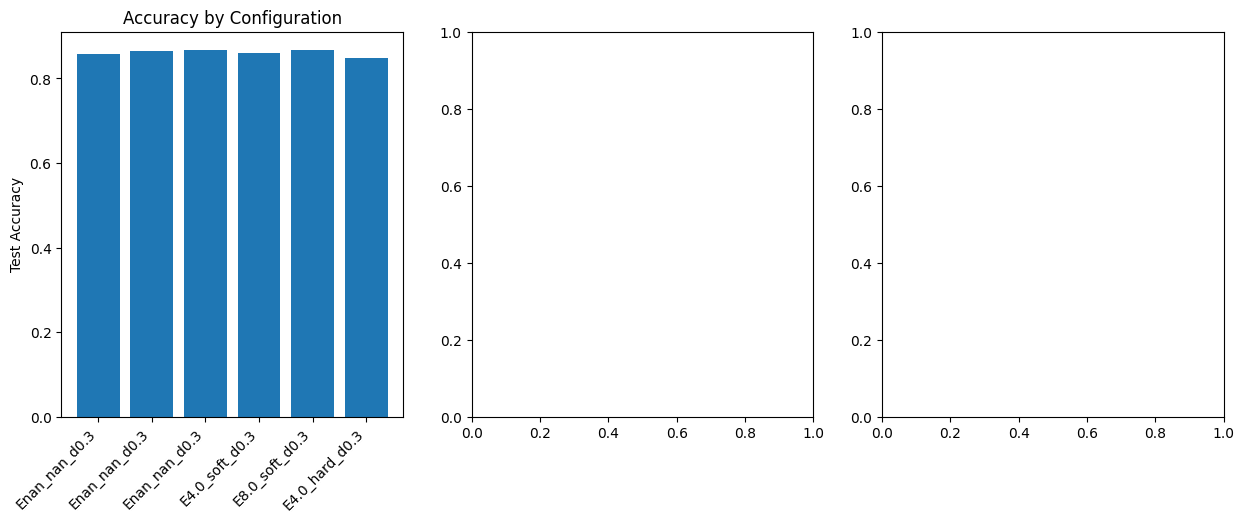

In [2]:
from nlp_moe_model import BertDenseBaseline
def run_ablation_study2():
    """Compare different configurations including dense baseline"""
    results = []

    # Configurations to test
    configs = [
        # Baselines (no MoE)
        {'type': 'dense', 'hidden_mult': 1, 'dropout': 0.3},  # Simple baseline
        {'type': 'dense', 'hidden_mult': 4, 'dropout': 0.3},  # Equivalent capacity to 4 experts
        {'type': 'dense', 'hidden_mult': 8, 'dropout': 0.3},  # Equivalent capacity to 8 experts

        # MoE configurations
        {'type': 'moe', 'num_experts': 4, 'routing': 'soft', 'dropout': 0.3},
        {'type': 'moe', 'num_experts': 8, 'routing': 'soft', 'dropout': 0.3},
        {'type': 'moe', 'num_experts': 4, 'routing': 'hard', 'dropout': 0.3},
    ]

    device = t.device('cuda:0' if t.cuda.is_available() else 'cpu')
    train_df, test_df, label_encoder, sentiment_encoder = load_data(
        '/home/knwldgosint/Documents/School5/Advanced Neural network/project/Arna/dataset/train_with_sentiment.csv',
        '/home/knwldgosint/Documents/School5/Advanced Neural network/project/Arna/dataset/test_with_sentiment.csv'
    )
    tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

    train_dataset = NewsDataset(
        train_df['Description'].tolist(),
        train_df['label_encoded'].tolist(),
        train_df['Sentiment_encoded'].tolist(),
        tokenizer, max_length=MAX_LEN
    )
    test_dataset = NewsDataset(
        test_df['Description'].tolist(),
        test_df['label_encoded'].tolist(),
        test_df['Sentiment_encoded'].tolist(),
        tokenizer, max_length=MAX_LEN
    )

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=4)

    for config in configs:
        print(f"\n{'='*50}")
        print(f"Testing: {config}")
        print('='*50)

        if config['type'] == 'dense':
            from nlp_moe_model import BertDenseBaseline
            model = BertDenseBaseline(
                pretrained_model_name=MODEL_NAME,
                output_dim=len(label_encoder.classes_),
                hidden_multiplier=config['hidden_mult'],
                freeze_bert=True,
                dropout=config['dropout']
            ).to(device)
            config_name = f"Dense_x{config['hidden_mult']}"
        else:
            model = MoEBertModel(
                pretrained_model_name=MODEL_NAME,
                expert_number=config['num_experts'],
                output_dim=len(label_encoder.classes_),
                routing=config['routing'],
                top_k=2,
                freeze_bert=True,
                dropout=config['dropout']
            ).to(device)
            config_name = f"MoE_{config['num_experts']}E_{config['routing']}"

        # Count parameters
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

        criterion = nn.CrossEntropyLoss()
        optimizer = t.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

        for epoch in range(2):
            if config['type'] == 'moe':
                train_loss, train_acc, metrics = train_epoch(
                    model, train_loader, optimizer, criterion, device,
                    load_balance=True, balance_coef=0.1
                )
            else:
                # Dense baseline doesn't need load balancing
                train_loss, train_acc, _ = train_epoch(
                    model, train_loader, optimizer, criterion, device,
                    load_balance=False
                )

        test_loss, test_acc = evaluate(model, test_loader, criterion, device)

        results.append({
            'config_name': config_name,
            'type': config['type'],
            'test_acc': test_acc,
            'trainable_params': trainable_params,
            **{k: v for k, v in config.items() if k != 'type'}
        })

        t.cuda.empty_cache()

    return pd.DataFrame(results)

df = run_ablation_study2()
plot_ablation_results(df)